In [3]:
import torch

from commons import *
import random
import itertools
from time import time

# open the file with data

In [4]:
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight

def calculateAllCut(q_torch, s):
    '''

    :param q_torch: The adjacent matrix of the graph
    :param s: The binary output from the neural network. s will be in form of [[prob1, prob2, ..., prob n], ...]
    :return: The calculated cut loss value
    '''
    if len(s) > 0:
        totalCuts = len(s[0])
        CutValue = 0
        for i in range(totalCuts):
            CutValue += partition_weight(q_torch, s[:,i])
        return CutValue/2
    return 0


# Finding a 3 way-cut mincut

In [181]:
heurestic_cut_3 = []
heurestic_cut_k = []
test_item = open_file(obj = test_item, filename='./testData/400-600.pkl')

# pos = nx.kamada_kawai_layout(test_item[1][2])
# nx.draw(test_item[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])
# labels = nx.get_edge_attributes(test_item[1][2],'weight')
# nx.draw_networkx_edge_labels(test_item[1][2],pos,edge_labels=labels)

for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    cut_value, (part_1, part_2) = nx.minimum_cut(graph, 200, 399)

    heurestic_cut_3.append(cut_value)
    print("Heurestic 2-way min-cut value: " + str(heurestic_cut_3[-1]), len(part_1), len(part_2))

    l = find_k_way_cut(graph, [0,200,399])
    # print(l)
    heurestic_cut_k.append(l[0])
    print("Heurestic k-way 3 min-cut value: " + str(heurestic_cut_k[-1]), l[1][0].number_of_nodes(), l[1][200].number_of_nodes(), l[1][399].number_of_nodes())

    l = find_k_way_cut(graph, [0,200,299, 399])
    # print(l)
    heurestic_cut_k.append(l[0])
    print("Heurestic k-way 3 min-cut value: " + str(heurestic_cut_k[-1]), l[1][0].number_of_nodes(), l[1][200].number_of_nodes(), l[1][399].number_of_nodes(), l[1][299].number_of_nodes())
    #
    # heurestic_cut_k.append(find_k_way_cut(graph, [0,20,60,85,98])[0])
    # print("Heurestic k-way 5 min-cut value: " + str(heurestic_cut_k[-1]))

Heurestic 2-way min-cut value: 27705 562 1


KeyboardInterrupt: 

In [30]:
save_object(heurestic_cut_k, './testData/heurestic_cut_k.pkl')

In [5]:
import networkx as nx
from itertools import combinations

def max_cut_value(G, node1, node2):
    """
    Compute the maximum cut value between two nodes by checking all combinations of partitions.
    """
    best_cut_value = 0
    for cut_set in combinations(G.nodes, len(G.nodes) // 2):
        cut_value = nx.cut_size(G, cut_set)
        if cut_value > best_cut_value:
            best_cut_value = cut_value
            best_cut_set = cut_set
    return best_cut_value, best_cut_set

def multi_max_cut(G, node1, node2, node3):
    """
    Perform multi-max cut by finding max cut between node1 and node2, then deciding the next max cut based on node3's partition.
    """
    max_cut_12, cut_set_12 = max_cut_value(G, node1, node2)

    # Determine which partition node3 is in
    if node3 in cut_set_12:
        # Node3 is in the same partition as node1
        G1_nodes = cut_set_12
        G2_nodes = set(G.nodes) - set(G1_nodes)
    else:
        # Node3 is in the same partition as node2
        G2_nodes = cut_set_12
        G1_nodes = set(G.nodes) - set(G2_nodes)

    # Create subgraphs
    G1 = G.subgraph(G1_nodes)
    G2 = G.subgraph(G2_nodes)

    if node3 in G1:
        # Find max cut between node1 and node3 in G1
        max_cut_13, cut_set_13 = max_cut_value(G1, node1, node3)
        return max_cut_13, cut_set_13
    else:
        # Find max cut between node2 and node3 in G2
        max_cut_23, cut_set_23 = max_cut_value(G2, node2, node3)
        return max_cut_23, cut_set_23

# Example usage
G = nx.Graph()
# Add edges to the graph
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (1, 5), (2, 4), (1, 3)])

node1 = 1
node2 = 2
node3 = 3

max_cut_value, max_cut_set = multi_max_cut(G, node1, node2, node3)
print(f"Maximum Cut Value: {max_cut_value}")
print(f"Cut Set: {max_cut_set}")


Maximum Cut Value: 1
Cut Set: (2,)


NameError: name 'edges' is not defined

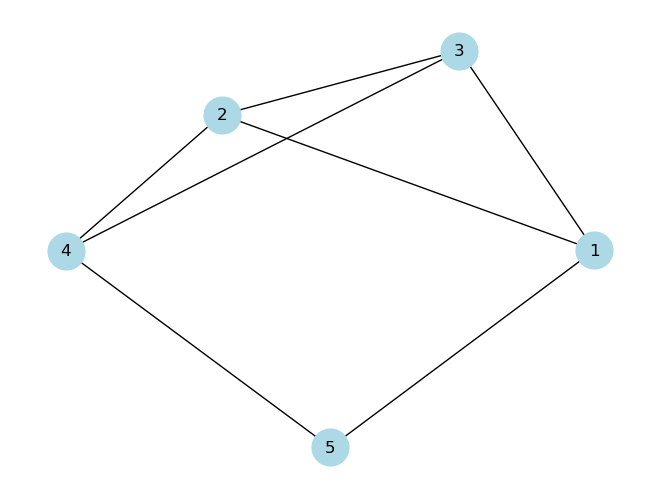

In [6]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue")
edge_labels = {edge: f'{cap}' for edge, cap in zip(edges, capacities)}
nx.draw_networkx_edge_labels(nx_g, pos, edge_labels=edge_labels)
plt.show()

In [7]:
import networkx as nx
import random

def initialize_partition(G, node1, node4):
    """ Initialize partitions with node1 and node4 in separate sets. """
    nodes = set(G.nodes())
    A = {node1}
    B = {node4}
    nodes.remove(node1)
    nodes.remove(node4)
    for node in nodes:
        if random.random() > 0.5:
            A.add(node)
        else:
            B.add(node)
    return A, B

def one_exchange(G, A, B, node1, node4):
    """ Perform one-exchange operations, ensuring node1 and node4 remain in separate partitions. """
    improved = True
    while improved:
        improved = False
        for node in list(A | B):
            if node in {node1, node4}:
                continue  # Skip the constraint nodes
            current_cut = calculate_cut_size(G, A, B)
            if node in A:
                new_A = A - {node}
                new_B = B | {node}
            else:
                new_A = A | {node}
                new_B = B - {node}
            new_cut = calculate_cut_size(G, new_A, new_B)
            if new_cut > current_cut:
                A, B = new_A, new_B
                improved = True
    return A, B

def calculate_cut_size(G, A, B):
    return sum(1 for (u, v) in G.edges() if (u in A and v in B) or (u in B and v in A))

# Example usage
# G = nx.gnp_random_graph(10, 0.3, seed=42)
node1, node4 = 0, 6  # Assuming these nodes are in the graph
A, B = initialize_partition(G, node1, node4)
A, B = one_exchange(G, A, B, node1, node4)
print("Partition A:", A)
print("Partition B:", B)



KeyError: 0

In [8]:
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'reg_random':
        print(f'Generating d-regular random graph with n={n}, d={d}')
        nx_temp = nx.random_regular_graph(d=d, n=n)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    nx_graph.order()
    return nx_graph

G = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=1)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1

Generating d-regular graph with n=80, d=3, seed=1


In [13]:
import random
import networkx as nx

def initialize_solution(graph, source, sink):
    # Initial solution with source in one partition and sink in the other
    partition = {node: random.choice([0, 1]) for node in graph.nodes() if node != source and node != sink}
    partition[source] = 0
    partition[sink] = 1
    return partition

def evaluate_cut(graph, partition):
    cut_value = 0
    for u, v, weight in graph.edges(data='weight', default=1):
        if partition[u] != partition[v]:
            cut_value += weight
    return cut_value

def local_search(graph, partition, source, sink):
    improved = True
    while improved:
        improved = False
        for node in graph.nodes():
            if node == source or node == sink:
                continue
            original_partition = partition[node]
            partition[node] = 1 - partition[node]
            new_cut_value = evaluate_cut(graph, partition)
            if new_cut_value <= evaluate_cut(graph, partition):
                partition[node] = original_partition
            else:
                improved = True
    return partition

def perturb_solution(graph, partition, source, sink, perturbation_strength):
    for _ in range(perturbation_strength):
        node = random.choice(list(graph.nodes))
        if node == source or node == sink:
            continue
        partition[node] = 1 - partition[node]
    return partition

def breakout_local_search(graph, source, sink, max_iterations, perturbation_strength):
    partition = initialize_solution(graph, source, sink)
    best_partition = partition.copy()
    best_cut_value = evaluate_cut(graph, best_partition)

    for _ in range(max_iterations):
        partition = local_search(graph, partition, source, sink)
        current_cut_value = evaluate_cut(graph, partition)

        if current_cut_value > best_cut_value:
            best_partition = partition.copy()
            best_cut_value = current_cut_value

        partition = perturb_solution(graph, partition, source, sink, perturbation_strength)

    return best_partition, best_cut_value

# Example usage
# graph = nx.Graph()
# graph.add_edge('A', 'B', weight=1)
# graph.add_edge('B', 'C', weight=1)
# graph.add_edge('C', 'D', weight=1)
# graph.add_edge('D', 'A', weight=1)
# graph.add_edge('A', 'C', weight=1)
# graph.add_edge('B', 'D', weight=1)




In [197]:
partitions[40].nodes(), partitions[40].number_of_nodes(), partitions[10].nodes(), partitions[10].number_of_nodes(), partitions[70].nodes(), partitions[70].number_of_nodes()

(NodeView((66, 37, 7, 40, 43, 13, 14, 15, 78, 49, 18, 20, 21, 55, 23, 28, 30)),
 17,
 NodeView((0, 3, 5, 9, 10, 11, 16, 17, 22, 24, 27, 29, 31, 32, 35, 36, 38, 39, 41, 46, 47, 48, 50, 52, 53, 56, 57, 58, 60, 61, 63, 67, 68, 69, 72, 73, 76)),
 37,
 NodeView((1, 2, 4, 6, 8, 12, 19, 25, 26, 33, 34, 42, 44, 45, 51, 54, 59, 62, 64, 65, 70, 71, 74, 75, 77, 79)),
 26)

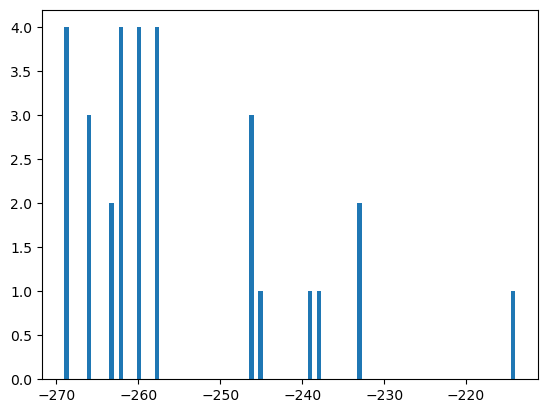

Mean cut cost: -255.33333333333334, Max cut cost: -214.0


In [137]:
import cvxpy as cvx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def solve_max_cut_with_constraints(G, node1, node4):
    n = G.number_of_nodes()
    L = nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()

    # SDP solution setup
    X = cvx.Variable((n, n), PSD=True)
    obj = 0.25 * cvx.trace(L @ X)  # Use matrix multiplication
    constr = [cvx.diag(X) == 1]  # Diagonal elements must be 1
    constr += [X[node1, node4] == -1]  # Enforce node1 and node4 to be in different partitions

    problem = cvx.Problem(cvx.Maximize(obj), constraints=constr)
    problem.solve(solver=cvx.SCS)  # Use a solver that handles semidefinite problems

    # GW algorithm implementation
    u, s, v = np.linalg.svd(X.value)
    U = u @ np.diag(np.sqrt(s))

    num_trials = 30
    gw_results = np.zeros(num_trials)
    for i in range(num_trials):
        r = np.random.randn(n)
        r = r / np.linalg.norm(r)
        cut = np.sign(r @ U.T)
        gw_results[i] = cut_cost(cut, L)

    # Visualization of results
    plt.hist(gw_results, bins=100)
    plt.show()
    return (np.mean(gw_results), np.max(gw_results))

def cut_cost(cut, L):
    """A function to calculate the cut cost given a cut and the Laplacian matrix."""
    cut_vector = np.where(cut > 0, 1, -1)
    return -0.25 * cut_vector.T @ L @ cut_vector  # -0.25 because L was used directly

# Example usage
# G = nx.gnp_random_graph(10, 0.5, seed=42)
mean_cost, max_cost = solve_max_cut_with_constraints(G, 1, 4)
print(f"Mean cut cost: {mean_cost}, Max cut cost: {max_cost}")


# Using integer solver

/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_15121/2644431824.py:25: DeprecationWarning: new_param is deprecated: Use picos.Constant instead.
  cc=pc.new_param('c',c)


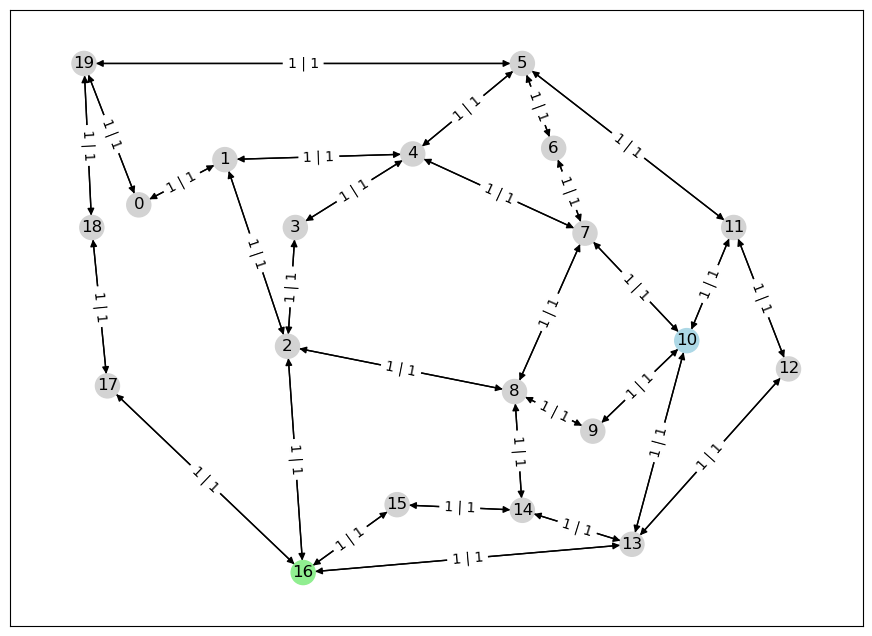

In [10]:
import picos as pc
import networkx as nx
import pylab
import random

# Use a fixed RNG seed so the result is reproducible.
random.seed(1)

# Number of nodes.
N=20

# Generate a graph using LCF notation.
G=nx.LCF_graph(N,[1,3,14],5)
G=nx.DiGraph(G) #edges are bidirected

# Generate edge capacities.
c={}
for e in sorted(G.edges(data=True)):
    capacity = random.randint(1, 20)
    e[2]['capacity'] = 1
    e[2]['weight'] = 1
    c[(e[0], e[1])]  = 1

# Convert the capacities to a PICOS expression.
cc=pc.new_param('c',c)

# Manually set a layout for which the graph is planar.
pos={
    0:  (0.07, 0.70), 1:  (0.18, 0.78), 2:  (0.26, 0.45), 3:  (0.27, 0.66),
    4:  (0.42, 0.79), 5:  (0.56, 0.95), 6:  (0.60, 0.80), 7:  (0.64, 0.65),
    8:  (0.55, 0.37), 9:  (0.65, 0.30), 10: (0.77, 0.46), 11: (0.83, 0.66),
    12: (0.90, 0.41), 13: (0.70, 0.10), 14: (0.56, 0.16), 15: (0.40, 0.17),
    16: (0.28, 0.05), 17: (0.03, 0.38), 18: (0.01, 0.66), 19: (0.00, 0.95)
}

# Set source and sink nodes for flow computation.
s=16
t=10

# Set node colors.
node_colors=['lightgrey']*N
node_colors[s]='lightgreen' # Source is green.
node_colors[t]='lightblue'  # Sink is blue.

# Define a plotting helper that closes the old and opens a new figure.
def new_figure():
    try:
        global fig
        pylab.close(fig)
    except NameError:
        pass
    fig=pylab.figure(figsize=(11,8))
    fig.gca().axes.get_xaxis().set_ticks([])
    fig.gca().axes.get_yaxis().set_ticks([])

# Plot the graph with the edge capacities.
new_figure()
nx.draw_networkx(G, pos, node_color=node_colors)
labels={
    e: '{} | {}'.format(c[(e[0], e[1])], c[(e[1], e[0])])
    for e in G.edges if e[0] < e[1]}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
pylab.show()

In [216]:
import cvxopt as cvx
import cvxopt.lapack
import numpy as np

# Make G undirected.
G=nx.Graph(G)

# Allocate weights to the edges.
for (i,j) in G.edges():
    G[i][j]['weight']=c[i,j]+c[j,i]

maxcut = pc.Problem()

# Add the symmetric matrix variable.
X=maxcut.add_variable('X', (N,N), 'symmetric')

# Retrieve the Laplacian of the graph.
LL = 1/4.*nx.laplacian_matrix(G).todense()
L=pc.new_param('L', LL)

# Constrain X to have ones on the diagonal.
maxcut.add_constraint(pc.diag_vect(X) == 1)

# Constrain X to be positive semidefinite.
maxcut.add_constraint(X >> 0)

# add constraint for maxcut
# maxcut.add_constraint(X[0, 7] == -1)
# maxcut.add_constraint(X[7, 0] == -1)
# maxcut.set_objective('max', L|X - 10 * X[0, 14])
# maxcut.add_constraint(X[0, 14] <= -0.5)
# maxcut.add_constraint(X[14, 0] <= -0.5)
# maxcut.add_constraint(X[0] == 0)
# maxcut.add_constraint(X[14] == 1)
# Set the objective.
maxcut.set_objective('max', L|X)

# print(maxcut)

# Solve the problem.
maxcut.solve(solver='cvxopt')

#print('bound from the SDP relaxation: {0}'.format(maxcut.obj_value()))
# Use a fixed RNG seed so the result is reproducable.
cvx.setseed(1)

# Perform a Cholesky factorization.
V=X.value

# optimal value.
count=0
obj_sdp=maxcut.obj_value()
obj=0
while (count < 100 or obj < 0.878*obj_sdp):
    r=cvx.normal(20,1)
    x=cvx.matrix(np.sign(V*r))
    o=(x.T*L*x).value
    if o > obj:
        x_cut=x
        obj=o
    count+=1
x=x_cut

# Extract the cut and the seperated node sets.
S1=[n for n in range(N) if x[n]<0]
S2=[n for n in range(N) if x[n]>0]
cut = [(i,j) for (i,j) in G.edges() if x[i]*x[j]<0]
leave = [e for e in G.edges if e not in cut]

/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_55589/3416749182.py:15: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
  X=maxcut.add_variable('X', (N,N), 'symmetric')
/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_55589/3416749182.py:19: DeprecationWarning: new_param is deprecated: Use picos.Constant instead.
  L=pc.new_param('L', LL)
/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_55589/3416749182.py:22: DeprecationWarning: diag_vect is deprecated: Use picos.maindiag instead.
  maxcut.add_constraint(pc.diag_vect(X) == 1)
/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_55589/3416749182.py:52: DeprecationWarning: Problem.obj_value is deprecated: Use value instead.
  obj_sdp=maxcut.obj_value()


/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_55589/359608592.py:18: DeprecationWarning: Problem.obj_value is deprecated: Use value instead.
  rval = maxcut.obj_value()


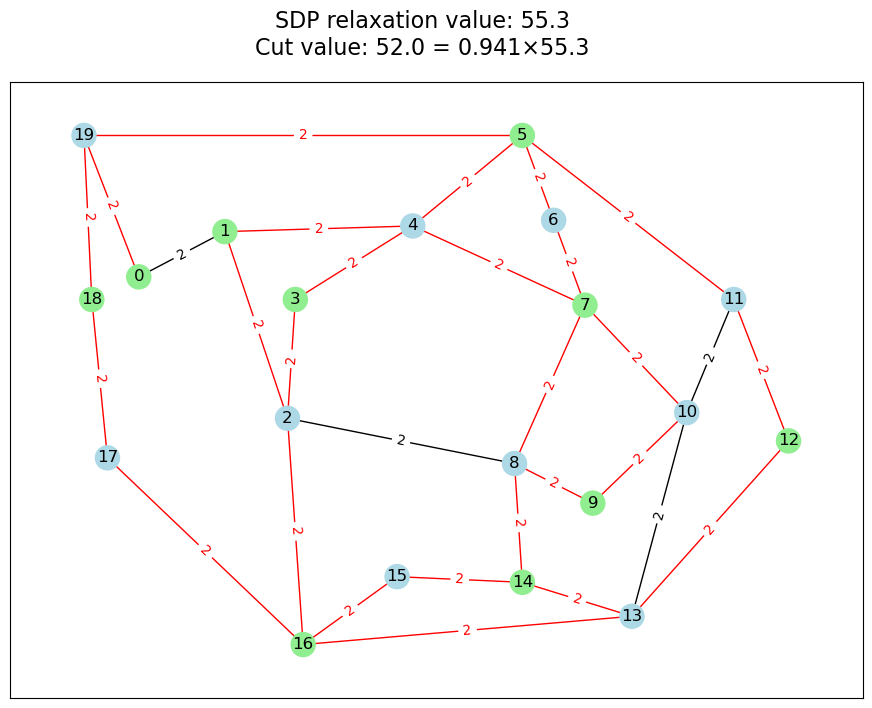

In [217]:
# Close the old figure and open a new one.
new_figure()

# Assign colors based on set membership.
node_colors=[('lightgreen' if n in S1 else 'lightblue') for n in range(N)]

# Draw the nodes and the edges that are not in the cut.
nx.draw_networkx(G, pos, node_color=node_colors, edgelist=leave)
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in leave}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Draw the edges that are in the cut.
nx.draw_networkx_edges(G, pos, edgelist=cut, edge_color='r')
labels={e: '{}'.format(G[e[0]][e[1]]['weight']) for e in cut}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='r')

# Show the relaxation optimum value and the cut capacity.
rval = maxcut.obj_value()
sval = sum(G[e[0]][e[1]]['weight'] for e in cut)
fig.suptitle(
    'SDP relaxation value: {0:.1f}\nCut value: {1:.1f} = {2:.3f}×{0:.1f}'
    .format(rval, sval, sval/rval), fontsize=16, y=0.97)

# Show the figure.
pylab.show()

# Using BLS

In [12]:
def recursive_cut_bls(graph, terminals, max_iterations = 50, perturbation_strength = 2):
    if len(terminals) <= 1 or graph.number_of_nodes() == 0:
        # Base case: no cut needed if only one terminal or graph is empty
        return 0, {terminals[0]: graph} if terminals else {}

    # Perform initial 2-way cut between the first two terminals
    best_cut_vale_item = 0
    best_partition_value = []
    for i in range(10):
        best_partition, best_cut_value = breakout_local_search(graph, terminals[0], terminals[1], max_iterations, perturbation_strength)
        if best_cut_value > best_cut_vale_item:
            best_cut_vale_item = best_cut_value
            best_partition_value = best_partition

    # cut_value, (part_1, part_2) = nx.minimum_cut(graph, terminals[0], terminals[1], flow_func=shortest_augmenting_path)
    cut_value = best_cut_vale_item
    # print(best_partition_value)
    part_1 = [key for key, value in best_partition_value.items() if value == 1]
    part_2 = [key for key, value in best_partition_value.items() if value == 0]

    graph_1, graph_2 = graph.subgraph(part_1).copy(), graph.subgraph(part_2).copy()

    # Determine which terminals are in each subgraph
    terminals_1, terminals_2 = [], []
    for terminal in terminals:
        if terminal in part_1:
            terminals_1.append(terminal)
        else:
            terminals_2.append(terminal)

    # Recursively apply cuts to each subgraph
    cut_value_1, partitions_1 = recursive_cut_bls(graph_1, terminals_1)
    cut_value_2, partitions_2 = recursive_cut_bls(graph_2, terminals_2)

    # Combine the results
    total_cut_value = cut_value + cut_value_1 + cut_value_2
    partitions = partitions_1
    partitions.update(partitions_2)  # Merge the two partition dictionaries

    return total_cut_value, partitions

In [293]:
G = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=300)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1

t_gnn_start = time()

cut_val, partitions = recursive_cut_bls(G, [10,40,70], 300, 2)


t_gnn = time() - t_gnn_start
print("Total Time: ", t_gnn)

# print("Best partition:", best_partition)
print("Best cut value:", cut_val)
print("Best cut value:", partitions)

Generating d-regular graph with n=80, d=3, seed=300
Total Time:  20.543044805526733
Best cut value: 91
Best cut value: {70: <networkx.classes.graph.Graph object at 0x2b8d1f8b0>, 40: <networkx.classes.graph.Graph object at 0x2ca1ff310>, 10: <networkx.classes.graph.Graph object at 0x2ba8eb0d0>}


In [294]:
len(partitions[40].nodes), len(partitions[10].nodes), len(partitions[70].nodes)

(21, 42, 17)

In [296]:
lst = []
for i in range(80):
    lst.append([0,0,0])

for n in    partitions[40].nodes:
    lst[n] = [1,0,0]
for n in    partitions[10].nodes:
    lst[n] = [0,1,0]
for n in    partitions[70].nodes:
    lst[n] = [0,0,1]

q_torch = qubo_dict_to_torch(G, gen_adj_matrix(G), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
cut = calculateAllCut(q_torch, torch.Tensor(lst))
cut

tensor(91., dtype=torch.float64)

# Geomans-williams algorithm for solving maxcut

In [253]:
import cvxpy as cvxpy
def goemans_williamson(graph) :
    """
    The Goemans-Williamson algorithm for solving the maxcut problem.

    Ref:
        Goemans, M.X. and Williamson, D.P., 1995. Improved approximation
        algorithms for maximum cut and satisfiability problems using
        semidefinite programming. Journal of the ACM (JACM), 42(6), 1115-1145
    Returns:
        np.ndarray: Graph coloring (+/-1 for each node)
        float:      The GW score for this cut.
        float:      The GW bound from the SDP relaxation
    """
    # Kudos: Originally implementation by Nick Rubin, with refactoring and
    # cleanup by Jonathon Ward and Gavin E. Crooks
    laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())

    # Setup and solve the GW semidefinite programming problem
    psd_mat = cvxpy.Variable(laplacian.shape, PSD=True)
    obj = cvxpy.Maximize(cvxpy.trace(laplacian * psd_mat))
    constraints = [cvxpy.diag(psd_mat) == 1]  # unit norm
    prob = cvxpy.Problem(obj, constraints)
    prob.solve(solver=cvxpy.CVXOPT)

    evals, evects = np.linalg.eigh(psd_mat.value)
    sdp_vectors = evects.T[evals > float(1.0E-6)].T

    # Bound from the SDP relaxation
    bound = np.trace(laplacian @ psd_mat.value)

    random_vector = np.random.randn(sdp_vectors.shape[1])
    random_vector /= np.linalg.norm(random_vector)
    colors = np.sign([vec @ random_vector for vec in sdp_vectors])
    score = colors @ laplacian @ colors.T

    return colors, score, bound

In [211]:
scores = [goemans_williamson(G)[1] for n in range(100)]
print(min(scores), max(scores))

/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)
/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(

46.0 52.0


In [254]:

# Use a fixed RNG seed so the result is reproducible.
random.seed(1)

# Number of nodes.
N=20

# Generate a graph using LCF notation.
G=nx.LCF_graph(N,[1,3,14],5)
G=nx.Graph(G) #edges are bidirected

# Generate edge capacities.
c={}
for e in sorted(G.edges(data=True)):
    capacity = random.randint(1, 20)
    e[2]['capacity'] = 1
    e[2]['weight'] = 1
    c[(e[0], e[1])]  = 1

# Convert the capacities to a PICOS expression.
cc=pc.new_param('c',c)

# Manually set a layout for which the graph is planar.
pos={
    0:  (0.07, 0.70), 1:  (0.18, 0.78), 2:  (0.26, 0.45), 3:  (0.27, 0.66),
    4:  (0.42, 0.79), 5:  (0.56, 0.95), 6:  (0.60, 0.80), 7:  (0.64, 0.65),
    8:  (0.55, 0.37), 9:  (0.65, 0.30), 10: (0.77, 0.46), 11: (0.83, 0.66),
    12: (0.90, 0.41), 13: (0.70, 0.10), 14: (0.56, 0.16), 15: (0.40, 0.17),
    16: (0.28, 0.05), 17: (0.03, 0.38), 18: (0.01, 0.66), 19: (0.00, 0.95)
}

all_items = [goemans_williamson(G) for n in range(100)]


/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_55589/114128866.py:20: DeprecationWarning: new_param is deprecated: Use picos.Constant instead.
  cc=pc.new_param('c',c)
/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 449 times so far.

  warnings.warn(msg, UserWarning)
/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication

In [255]:
scores = [n[1] for n in all_items]
print(max(scores))

idx = scores.index(max(scores))
main_item = all_items[idx]
main_item

26.0


(array([-1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1., -1.,  1., -1.,  1.]),
 26.0,
 27.630302418848586)

In [3]:
import numpy as np
import networkx as nx
import cvxpy as cvxpy
from typing import Tuple, List

def goemans_williamson_multi(graph: nx.Graph, terminals: List[int]) -> Tuple[np.ndarray, float, float]:
    def maxcut_between_two_nodes(graph, terminal1, terminal2):
        laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())
        psd_mat = cvxpy.Variable(laplacian.shape, PSD=True)
        obj = cvxpy.Maximize(cvxpy.trace(laplacian * psd_mat))
        constraints = [cvxpy.diag(psd_mat) == 1]  # unit norm
        prob = cvxpy.Problem(obj, constraints)
        prob.solve(solver=cvxpy.GUROBI)

        evals, evects = np.linalg.eigh(psd_mat.value)
        sdp_vectors = evects.T[evals > float(1.0E-6)].T

        # Bound from the SDP relaxation
        bound = np.trace(laplacian @ psd_mat.value)

        random_vector = np.random.randn(sdp_vectors.shape[1])
        random_vector /= np.linalg.norm(random_vector)
        colors = np.sign([vec @ random_vector for vec in sdp_vectors])
        score = colors @ laplacian @ colors.T

        return colors, score, bound

    def recursive_maxcut(graph, terminals):
        if len(terminals) == 2:
            return maxcut_between_two_nodes(graph, terminals[0], terminals[1])

        colors, score, bound = maxcut_between_two_nodes(graph, terminals[0], terminals[1])

        partition1 = [node for node, color in enumerate(colors) if color == 1]
        partition2 = [node for node, color in enumerate(colors) if color == -1]

        subgraph1 = graph.subgraph(partition1)
        subgraph2 = graph.subgraph(partition2)

        remaining_terminals = terminals[2:]
        next_terminal = remaining_terminals[0]

        if next_terminal in subgraph1:
            return recursive_maxcut(subgraph1, [terminals[0]] + remaining_terminals)
        else:
            return recursive_maxcut(subgraph2, [terminals[1]] + remaining_terminals)

    return recursive_maxcut(graph, terminals)

# Example usage:
# graph = nx. ... # Create or load your graph here
# terminals = [0, 1, 2] # List of terminal nodes
# colors, score, bound = mystery(graph, terminals)



In [8]:

# Use a fixed RNG seed so the result is reproducible.
random.seed(1)

# Number of nodes.
N=20

# Generate a graph using LCF notation.
G=nx.LCF_graph(N,[1,3,14],5)
G=nx.Graph(G) #edges are bidirected

# Generate edge capacities.
c={}
for e in sorted(G.edges(data=True)):
    capacity = random.randint(1, 20)
    e[2]['capacity'] = 1
    e[2]['weight'] = 1
    c[(e[0], e[1])]  = 1

# Convert the capacities to a PICOS expression.
cc=pc.new_param('c',c)

# Manually set a layout for which the graph is planar.
pos={
    0:  (0.07, 0.70), 1:  (0.18, 0.78), 2:  (0.26, 0.45), 3:  (0.27, 0.66),
    4:  (0.42, 0.79), 5:  (0.56, 0.95), 6:  (0.60, 0.80), 7:  (0.64, 0.65),
    8:  (0.55, 0.37), 9:  (0.65, 0.30), 10: (0.77, 0.46), 11: (0.83, 0.66),
    12: (0.90, 0.41), 13: (0.70, 0.10), 14: (0.56, 0.16), 15: (0.40, 0.17),
    16: (0.28, 0.05), 17: (0.03, 0.38), 18: (0.01, 0.66), 19: (0.00, 0.95)
}

all_items = [goemans_williamson_multi(G, [0,1]) for n in range(100)]


/var/folders/ct/dclkdf0s6954rm5c_45z7_vr0000gn/T/ipykernel_70680/4060393838.py:20: DeprecationWarning: new_param is deprecated: Use picos.Constant instead.
  cc=pc.new_param('c',c)
/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


SolverError: Either candidate conic solvers (['GUROBI']) do not support the cones output by the problem (Zero, PSD), or there are not enough constraints in the problem.

In [262]:
scores = [n[1] for n in all_items]
print(max(scores))

idx = scores.index(max(scores))
main_item = all_items[idx]
main_item # 26 for CXVOPT, 24 for SCS,

24.0


(array([ 1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,
         1., -1.,  1., -1.,  1.,  1., -1.]),
 24.0,
 27.63030386510035)

## GW algorithm

- Graph size: node = 80, d = 3
- Capacities = 1
- Terminals = 10, 40, 70

In [264]:
t_gnn_start = time()

G = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=1)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1

all_items = [goemans_williamson_multi(G, [10,40, 70]) for n in range(100)]

t_gnn = time() - t_gnn_start
print("Total Time: ",  t_gnn)


Generating d-regular graph with n=80, d=3, seed=1


/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1043 times so far.

  warnings.warn(msg, UserWarning)
/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1044 times so far.

  warnings

Total Time:  48.05269193649292


/Users/javaad/anaconda3/envs/COP/lib/python3.10/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1242 times so far.

  warnings.warn(msg, UserWarning)


In [265]:
scores = [n[1] for n in all_items]
print(max(scores))

idx = scores.index(max(scores))
main_item = all_items[idx]
main_item

48.0


(array([ 1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
        -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
        -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,
         1.]),
 48.0,
 59.65047343326047)

## Exp 2 - BLS

- expriment 2 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=500, d=3

In [14]:
G = generate_graph(n=500, d=3, p=None, graph_type='reg', random_seed=300)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1

t_gnn_start = time()

cut_val, partitions = recursive_cut_bls(G, [100,300,450], 200, 2)


t_gnn = time() - t_gnn_start
print("Huerestic Total Time: ", t_gnn)

# print("Best partition:", best_partition)
print("Best cut value:", cut_val)
print("Best cut value:", partitions)

Generating d-regular graph with n=500, d=3, seed=300
Huerestic Total Time:  397.60210728645325
Best cut value: 504
Best cut value: {300: <networkx.classes.graph.Graph object at 0x1483b4d30>, 450: <networkx.classes.graph.Graph object at 0x15a8a9de0>, 100: <networkx.classes.graph.Graph object at 0x15a8aae00>}


In [17]:
lst = []
for i in range(500):
    lst.append([0,0,0])

for n in    partitions[100].nodes:
    lst[n] = [1,0,0]
for n in    partitions[450].nodes:
    lst[n] = [0,1,0]
for n in    partitions[300].nodes:
    lst[n] = [0,0,1]

q_torch = qubo_dict_to_torch(G, gen_adj_matrix(G), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
cut = calculateAllCut(q_torch, torch.Tensor(lst))
cut

tensor(504., dtype=torch.float64)

In [19]:
len(G.nodes), len(G.edges)


(500, 750)

## Exp 3 - BLS

- expriment 2 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=1000, d=3

In [14]:
G = generate_graph(n=1000, d=3, p=None, graph_type='reg', random_seed=300)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1

t_gnn_start = time()

cut_val, partitions = recursive_cut_bls(G, [200,400,700], 200, 2)


t_gnn = time() - t_gnn_start
print("Huerestic Total Time: ", t_gnn)

# print("Best partition:", best_partition)
print("Best cut value:", cut_val)
print("Best cut value:", partitions)

Generating d-regular graph with n=1000, d=3, seed=300
Huerestic Total Time:  1582.7624459266663
Best cut value: 995
Best cut value: {400: <networkx.classes.graph.Graph object at 0x28acd3ee0>, 700: <networkx.classes.graph.Graph object at 0x28b7333d0>, 200: <networkx.classes.graph.Graph object at 0x28b7333a0>}
